In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shivamb/real-or-fake-fake-jobposting-prediction")

print("Path to dataset files:", path)

100%|██████████| 16.1M/16.1M [00:00<00:00, 112MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shivamb/real-or-fake-fake-jobposting-prediction/versions/1


Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import os
import kagglehub
import warnings
warnings.filterwarnings('ignore')

In [3]:
csv_file = None
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.csv'):
            csv_file = os.path.join(root, file)
            break

if csv_file:
    print(f"Found CSV file: {csv_file}")
    # Load the dataset
    df = pd.read_csv(csv_file)
else:
    raise FileNotFoundError("No CSV file found in the downloaded dataset.")

Found CSV file: /root/.cache/kagglehub/datasets/shivamb/real-or-fake-fake-jobposting-prediction/versions/1/fake_job_postings.csv


In [4]:
print(f"\nDataset shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())
print("\nClass distribution:")
print(df['fraudulent'].value_counts())
print(df['fraudulent'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))



Dataset shape: (17880, 18)

Column names:
['job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']

Class distribution:
fraudulent
0    17014
1      866
Name: count, dtype: int64
fraudulent
0    95.16%
1     4.84%
Name: proportion, dtype: object


In [5]:
print("\nMissing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Missing values per column:
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
dtype: int64


In [6]:
text_columns = ['title', 'location', 'department', 'company_profile',
                'description', 'requirements', 'benefits', 'employment_type',
                'required_experience', 'required_education', 'industry', 'function']

for col in text_columns:
    if col in df.columns:
        df[col] = df[col].fillna('')

df['text_features'] = df['title'] + ' ' + df['company_profile'] + ' ' + \
                     df['description'] + ' ' + df['requirements'] + ' ' + \
                     df['benefits']


In [7]:
categorical_features = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
for feature in categorical_features:
    if feature in df.columns:
        le = LabelEncoder()
        df[feature] = df[feature].fillna('Unknown')
        df[feature] = le.fit_transform(df[feature])

df['has_location'] = df['location'].apply(lambda x: 0 if x == '' else 1)


In [8]:
tfidf = TfidfVectorizer(max_features=3000, stop_words='english')
X_text = tfidf.fit_transform(df['text_features'])

numerical_features = ['telecommuting', 'has_company_logo', 'has_questions', 'has_location'] + categorical_features
X_numerical = df[numerical_features].values

In [9]:
from scipy.sparse import hstack
X = hstack([X_text, X_numerical])

y = df['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nTraining Random Forest model")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_resampled, y_train_resampled)

y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]



Training Random Forest model...


In [10]:
print("\nModel Evaluation:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)


Model Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.98      0.69      0.81       173

    accuracy                           0.98      3576
   macro avg       0.98      0.84      0.90      3576
weighted avg       0.98      0.98      0.98      3576


Confusion Matrix:
[[3400    3]
 [  54  119]]


Confusion matrix saved as 'confusion_matrix.png'


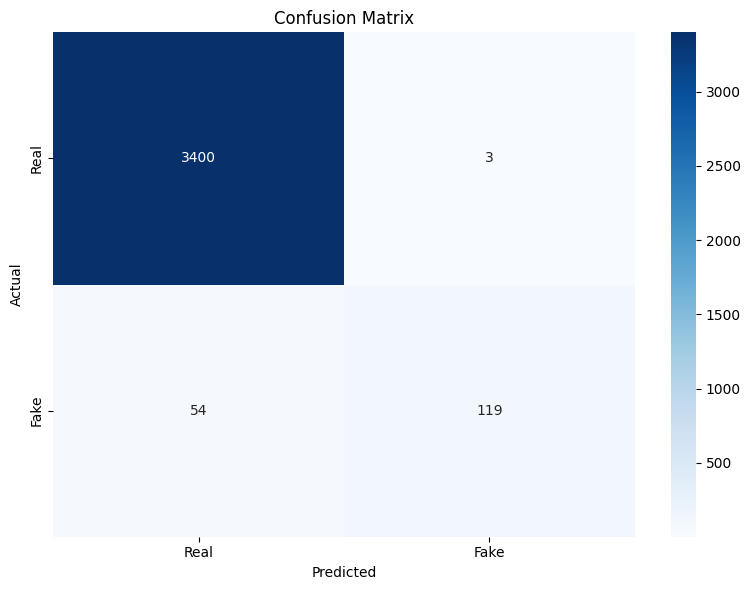

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

In [12]:
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC AUC Score: {auc_score:.4f}")

feature_names = tfidf.get_feature_names_out().tolist() + numerical_features
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
})



ROC AUC Score: 0.9920



Top 20 important features:
               feature  importance
3001  has_company_logo    0.061420
3002     has_questions    0.018489
881               earn    0.014737
3008          function    0.011918
1                  000    0.010966
1245           growing    0.009717
500           clerical    0.007270
199         applicable    0.007181
2692              team    0.006922
941         encouraged    0.006425
2742              time    0.006251
975              entry    0.006062
2929               web    0.005681
2957              word    0.005318
3007          industry    0.005293
2500            skills    0.005289
112     administrative    0.005117
875             duties    0.005002
501              clerk    0.004971
335           benefits    0.004791
Feature importance plot saved as 'feature_importance.png'


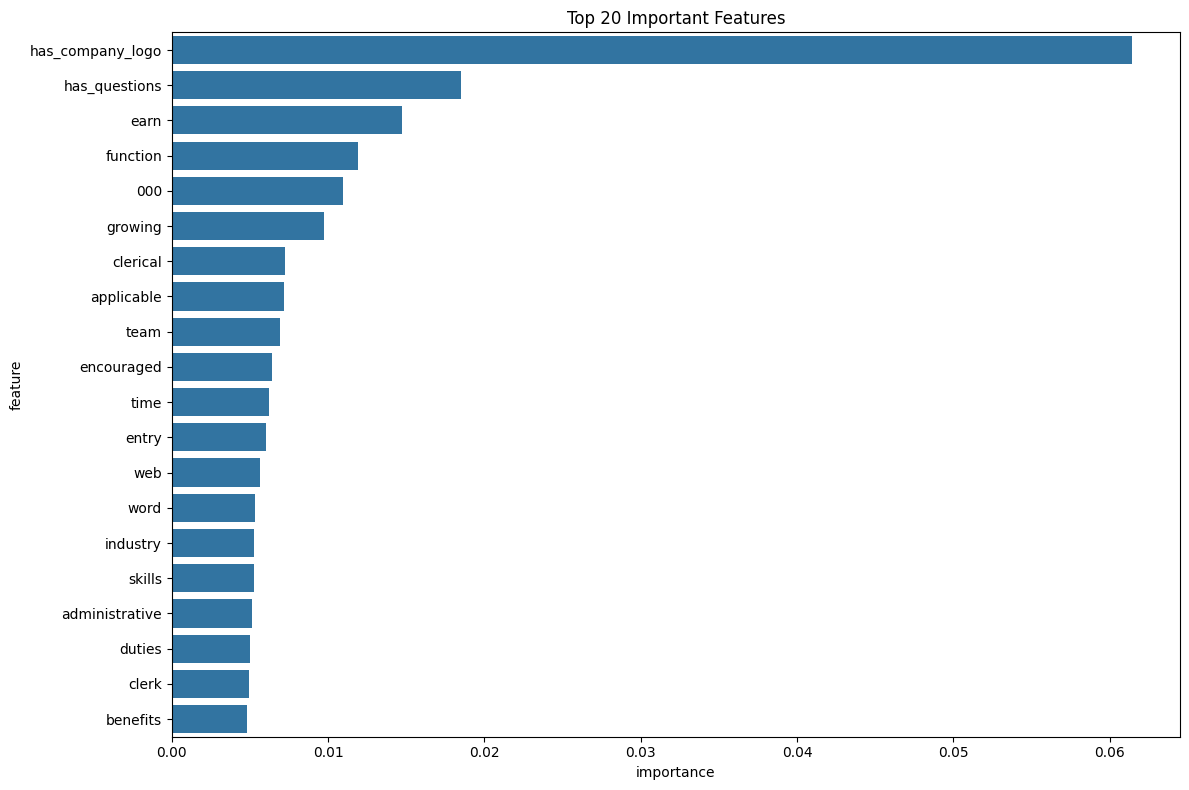

In [13]:
print("\nTop 20 important features:")
top_features = feature_importance.sort_values('importance', ascending=False).head(20)
print(top_features)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
print("Feature importance plot saved as 'feature_importance.png'")

In [15]:
def predict_fake_job(job_posting):
    """
    Predict if a job posting is fake.

    Parameters:
    job_posting (dict): A dictionary containing job posting details

    Returns:
    tuple: (prediction, probability)
    """
    text_feature = job_posting.get('title', '') + ' ' + \
                  job_posting.get('company_profile', '') + ' ' + \
                  job_posting.get('description', '') + ' ' + \
                  job_posting.get('requirements', '') + ' ' + \
                  job_posting.get('benefits', '')

    X_text_new = tfidf.transform([text_feature])
    X_num_new = np.array([[
        job_posting.get('telecommuting', 0),
        job_posting.get('has_company_logo', 0),
        job_posting.get('has_questions', 0),
        1 if job_posting.get('location', '') != '' else 0,

    ]])

    X_new = hstack([X_text_new, X_num_new])

    pred = rf_model.predict(X_new)[0]
    prob = rf_model.predict_proba(X_new)[0, 1]

    return pred, prob


In [19]:
print("\nExample prediction:")
sample_job = df.sample(1).iloc[0].to_dict()
actual_label = sample_job.pop('fraudulent')
pred, prob = predict_fake_job(sample_job)
print(f"Actual: {'Fake' if actual_label == 1 else 'Real'}")
print(f"Predicted: {'Fake' if pred == 1 else 'Real'} with probability: {prob:.4f}")


Example prediction:
Actual: Real
Predicted: Real with probability: 0.1800


# Test on multiple random examples

In [27]:

print("\nMultiple random predictions:")
num_samples = 5
sample_jobs = df.sample(num_samples)

for i, (idx, row) in enumerate(sample_jobs.iterrows()):
    job_dict = row.to_dict()
    actual_label = job_dict.pop('fraudulent')
    pred, prob = predict_fake_job(job_dict)
    print(f"Example {i+1}:")
    print(f"Actual: {'Fake' if actual_label == 1 else 'Real'}")
    print(f"Predicted: {'Fake' if pred == 1 else 'Real'} with probability: {prob:.4f}")
    print("---")


Multiple random predictions:
Example 1:
Actual: Fake
Predicted: Fake with probability: 0.9600
---
Example 2:
Actual: Real
Predicted: Real with probability: 0.1100
---
Example 3:
Actual: Real
Predicted: Real with probability: 0.0100
---
Example 4:
Actual: Real
Predicted: Real with probability: 0.0000
---
Example 5:
Actual: Real
Predicted: Real with probability: 0.1400
---
